<a href="https://colab.research.google.com/github/ashish1610dhiman/pinn_option_pricing/blob/main/european_call_pricing_0_ad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from io import IncrementalNewlineDecoder
import torch
import torch.autograd as tgrad
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
%matplotlib inline

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)

### Useful links
* https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
* https://www.investopedia.com/terms/b/blackscholes.asp
* https://www.mathworks.com/help/symbolic/the-black-scholes-formula-for-call-option-price.html
* https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
* https://medium.com/@andeyharsha15/deep-neural-networks-for-solving-differential-equations-in-finance-da662ef0681

### Analytical solution

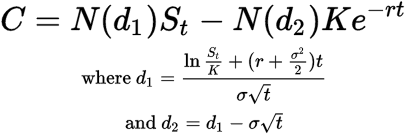

In [ ]:
S = torch.Tensor([80]).requires_grad_()
t = torch.Tensor([0]).requires_grad_()
sigma = torch.Tensor([0.3]).requires_grad_()
r = torch.Tensor([0.05]).requires_grad_()
K = torch.Tensor([70])
T = torch.Tensor([1])
t2m = T-t

d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * t2m)/(sigma * torch.sqrt(t2m))
d2 = d1 - sigma * torch.sqrt(t2m)

In [ ]:
N0 = lambda value: 0.5 * (1 + torch.erf((value/2**0.5))) #normal cdf
Nd1 = N0(d1)
Nd2 = N0(d2)
C = S* Nd1 - K* Nd2 *torch.exp(-r*t2m)
print("Option Price:", C.item())

Option Price: 17.01496124267578


### Differential eqn

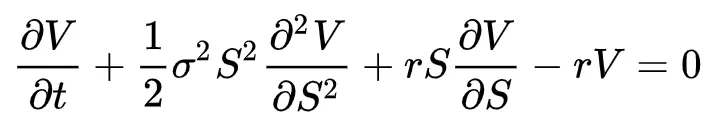

In [ ]:
dCdt = tgrad.grad(C, t, create_graph=True, only_inputs=True)[0]
dCdt

tensor([-5.8385], grad_fn=<NegBackward0>)

In [ ]:
dCdS = tgrad.grad(C, S, create_graph=True, only_inputs=True)[0]
d2CdS2 = tgrad.grad(dCdS, S, create_graph=True, only_inputs=True)[0]
dCdvol = tgrad.grad(C, sigma, create_graph=True, only_inputs=True)[0]
dCdS,d2CdS2,dCdvol

(tensor([0.7769], grad_fn=<AddBackward0>),
 tensor([0.0124], grad_fn=<AddBackward0>),
 tensor([23.8776], grad_fn=<AddBackward0>))

In [ ]:
dCdt.item() + ((0.5*sigma**2) * (S**2)*d2CdS2.item() )+ r*S*dCdS.item() - r*C

tensor([0.], grad_fn=<SubBackward0>)

### PDE Modelling for European option

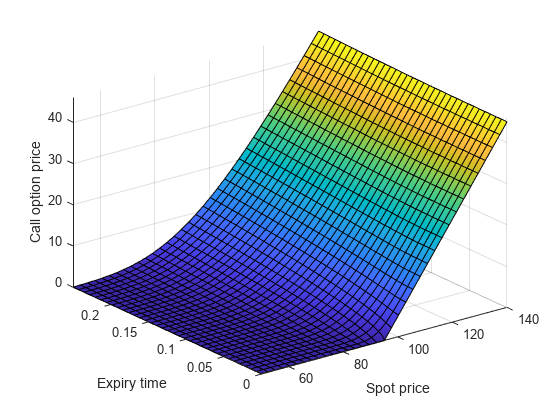

In [ ]:
K = 40
r = 0.05
sigma = 0.15
T = 1
S_range = [0, 160]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)

In [ ]:
def get_diff_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        np.random.uniform(*S_range, (n, 1))], axis=1)
    y = np.zeros((n, 1)) #price
    return X, y

# get_diff_data(10)

In [ ]:
def get_ivp_data(n):
    X = np.concatenate([np.ones((n, 1)), #all at expiry time
                    np.random.uniform(*S_range, (n, 1))], axis=1)
    y = gs(X[:, 1]).reshape(-1, 1)

    return X, y

# get_ivp_data(10)

In [ ]:
def get_bvp_data(n):
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[0] * np.ones((n, 1))], axis=1)
    y1 = np.zeros((n, 1))

    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[-1] * np.ones((n, 1))], axis=1)
    y2 = (S_range[-1] - K*np.exp(-r*(T-X2[:, 0].reshape(-1)))).reshape(-1, 1)

    return X1, y1, X2, y2



* BVP 1 $S = S_{min}$: 0

* BVP2 ($S = S_{max}$): $S_{max} - K \cdot e^{-rt}$

* IVP (t=T): $max(S-K,0)$ *call this initial but corresponds to expiry*

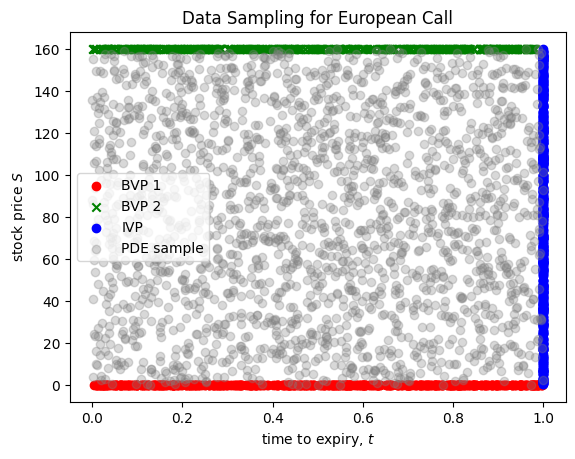

In [ ]:
bvp_x1,bvp_y1,bvp_x2,bvp_y2 = get_bvp_data(500)
ivp_x1,ivp_y1 = get_ivp_data(500)
diff_x1,diff_y1 = get_diff_data(2000)
plt.scatter(bvp_x1[:,0],bvp_x1[:,1], label= "BVP 1", color = "red",marker="o")
plt.scatter(bvp_x2[:,0],bvp_x2[:,1], label= "BVP 2", color = "green",marker="x")
plt.scatter(ivp_x1[:,0],ivp_x1[:,1], label= "IVP", color = "blue")
plt.scatter(diff_x1[:,0],diff_x1[:,1], label= "PDE sample", color = "grey", alpha = 0.3)
plt.xlabel("time to expiry, $t$")
plt.ylabel("stock price $S$")
plt.title("Data Sampling for European Call")
plt.legend()

# Simulation with PINN

In [ ]:
class european_call(nn.Module):
    "Defines a Phsyics informed network"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation1 = nn.LeakyReLU(negative_slope=0.1)
        activation2 = nn.Tanh()
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation1])
        self.fch = nn.Sequential(*[nn.Sequential(*[
                            nn.BatchNorm1d(N_HIDDEN),
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation1]) for _ in range(N_LAYERS)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### declare model

In [ ]:
model = european_call(2,1,100,8)
optimizer = torch.optim.Adam(model.parameters(),lr=7e-5)
print (f"Model parameters : {sum(p.numel() for p in model.parameters())/10**3:.2f}K")

Model parameters : 82.80K


In [ ]:
print (model)

european_call(
  (fcs): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (fch): Sequential(
    (0): Sequential(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=100, bi

In [ ]:
N_sample = 500
physics_lr = 1000

loss_history={
    "total_loss":[],"loss1":[],"loss2":[],\
    "loss_bvp1":[],"loss_bvp2":[],"loss_ivp":[],
}

for i in range(10000):
    optimizer.zero_grad()

    # Get IVP data
    ivp_x, ivp_y = get_ivp_data(N_sample)
    ivp_x_tensor = torch.from_numpy(ivp_x).float()
    ivp_y_tensor = torch.from_numpy(ivp_y).float()
    ivp_y_pred = model(ivp_x_tensor)
    mse_ivp = nn.MSELoss()(ivp_y_tensor, ivp_y_pred)

    # Get BVP data
    bvp_x1, bvp_y1, bvp_x2, bvp_y2 = get_bvp_data(N_sample)
    bvp_x1_tensor = torch.from_numpy(bvp_x1).float()
    bvp_y1_tensor = torch.from_numpy(bvp_y1).float()
    bvp_x2_tensor = torch.from_numpy(bvp_x2).float()
    bvp_y2_tensor = torch.from_numpy(bvp_y2).float()
    bvp_y1_pred = model(bvp_x1_tensor)
    mse_bvp1 = nn.MSELoss()(bvp_y1_tensor, bvp_y1_pred)
    bvp_y2_pred = model(bvp_x2_tensor)
    mse_bvp2 = nn.MSELoss()(bvp_y2_tensor, bvp_y1_pred)

    # Aggregate the "data loss"
    loss1 = mse_ivp + mse_bvp1 + mse_bvp2

    # Compute the "Black-Scholes loss"
    X1, y1 = get_diff_data(4*N_sample)
    X1 = torch.from_numpy(X1).float().requires_grad_()
    y1 = torch.from_numpy(y1).float()
    y1_hat = model(X1)
    grads = torch.autograd.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = torch.autograd.grad(dVdS, X1, grad_outputs=torch.ones(dVdS.shape), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    bs_pde = dVdt + 0.5 * ((sigma * S1) ** 2) * d2VdS2 + r * S1 * dVdS - r * y1_hat
    loss2 = physics_lr * nn.MSELoss()(bs_pde, torch.zeros_like(bs_pde))

    # Backpropagate joint loss
    loss = loss1 + loss2
    loss_history["total_loss"].append(loss.item())
    loss_history["loss1"].append(loss1.item())
    loss_history["loss2"].append(loss2.item())
    loss_history["loss_ivp"].append(mse_ivp.item())
    loss_history["loss_bvp1"].append(mse_bvp1.item())
    loss_history["loss_bvp2"].append(mse_bvp2.item())
    loss.backward()
    optimizer.step()


    # Plot the result as training progresses
    if (i + 1) % 500 == 0:
        print(f"Epoch {i+1}, Loss: {loss.item():.6f}")


Epoch 500, Loss: 15741.731445
Epoch 1000, Loss: 10187.009766
Epoch 1500, Loss: 8131.481934
Epoch 2000, Loss: 8345.174805
Epoch 2500, Loss: 7683.391602
Epoch 3000, Loss: 7744.700684
Epoch 3500, Loss: 7530.843262
Epoch 4000, Loss: 7537.068359
Epoch 4500, Loss: 7675.781250
Epoch 5000, Loss: 7491.579590
Epoch 5500, Loss: 7442.641113
Epoch 6000, Loss: 7489.197266
Epoch 6500, Loss: 7469.137695
Epoch 7000, Loss: 7638.784668
Epoch 7500, Loss: 7623.375488
Epoch 8000, Loss: 7530.276367
Epoch 8500, Loss: 7413.629395
Epoch 9000, Loss: 7482.937988
Epoch 9500, Loss: 7408.708496
Epoch 10000, Loss: 7531.487793


In [ ]:
loss_df = pd.DataFrame.from_dict(loss_history)
# loss_df["loss"] = loss_history
# loss_df["ma_100_loss"] = loss_df["loss"].rolling(100).mean()
# ax = loss_df.plot(y='loss', logy=True)
# loss_df.plot(y='ma_100_loss', ax=ax)
# ax.set_ylabel("Log loss")

In [ ]:
loss_df.head()

,total_loss,loss1,loss2,loss_bvp1,loss_bvp2,loss_ivp
0,19512.060547,18092.576172,1419.484253,0.185731,14540.509766,3551.880371
1,19533.712891,18150.449219,1383.264038,0.198118,14551.066406,3599.185547
2,19240.906250,18070.867188,1170.038452,0.203321,14544.097656,3526.565186
3,19359.007812,18219.359375,1139.648193,0.201126,14540.038086,3679.120117
4,19079.470703,18039.351562,1040.119751,0.209395,14527.738281,3511.404541


In [ ]:
loss_df.tail(100).mean()

total_loss    7432.102681
loss1         7332.079370
loss2          100.023314
loss_bvp1     3654.347820
loss_bvp2     3668.014822
loss_ivp         9.716738
dtype: float64

Text(0.5, 1.0, 'Total Training loss')

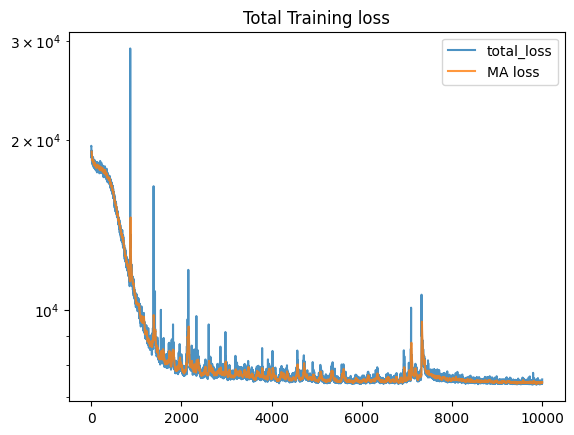

In [ ]:
ax = loss_df[["total_loss"]].plot(logy=True,alpha=0.8)
loss_df[["total_loss"]].rename(columns={"total_loss":"MA loss"}).rolling(10).mean().plot(logy=True,alpha=0.8, label="MA", ax = ax)
plt.title("Total Training loss")

Text(0.5, 1.0, 'Training Curve for Moving Average of losses')

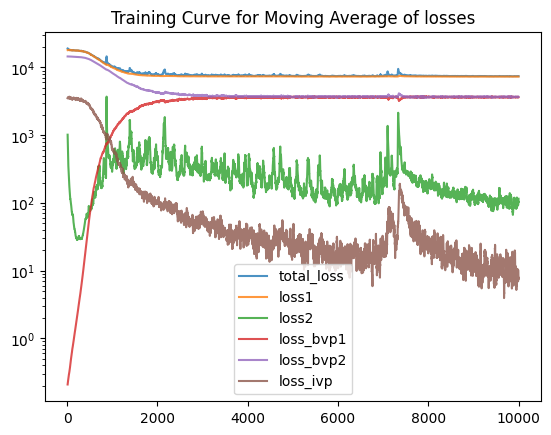

In [ ]:
loss_df.rolling(10).mean().plot(logy=True,alpha=0.8)
plt.title("Training Curve for Moving Average of losses")

<Axes: >

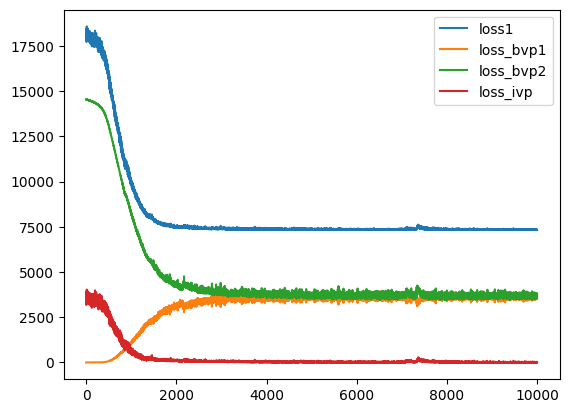

In [ ]:
loss_df[["loss1","loss_bvp1","loss_bvp2","loss_ivp"]].plot()

### Evaluation

In [ ]:
def eur_call_analytical_price(S, t, K, sigma):
    t2m = t  # Time to maturity (assumed in years)
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * t2m) / (sigma * torch.sqrt(t2m))
    d2 = d1 - sigma * torch.sqrt(t2m)
    # Normal cumulative distribution function (CDF)
    N0 = lambda value: 0.5 * (1 + torch.erf(value / (2**0.5)))
    Nd1 = N0(d1)
    Nd2 = N0(d2)
    # Calculate the option price
    C = S * Nd1 - K * Nd2 * torch.exp(-r * t2m)
    return C

In [ ]:
eur_call_analytical_price(torch.tensor([80]),torch.tensor([1]),torch.tensor([70]), sigma =0.30)

tensor([17.0150])

In [ ]:
s = np.linspace(S_range[0], S_range[1], 50)
t = np.linspace(t_range[0], t_range[1], 50)
s_grid, t_grid = np.meshgrid(s, t)

s_flat = s_grid.flatten()
t_flat = t_grid.flatten()

# Create a 2D tensor from the flattened arrays
X_test = torch.tensor(np.column_stack((t_flat, s_flat)), dtype=torch.float)

y_analytical_test = eur_call_analytical_price(X_test[:,1],X_test[:,0],torch.tensor([K]), sigma = sigma)
X_test.shape,y_analytical_test.shape

(torch.Size([2500, 2]), torch.Size([2500]))

In [ ]:
with torch.no_grad():
  y_pinn_test = model(X_test)

Text(0.5, 1.0, 'European Call Option pricing')

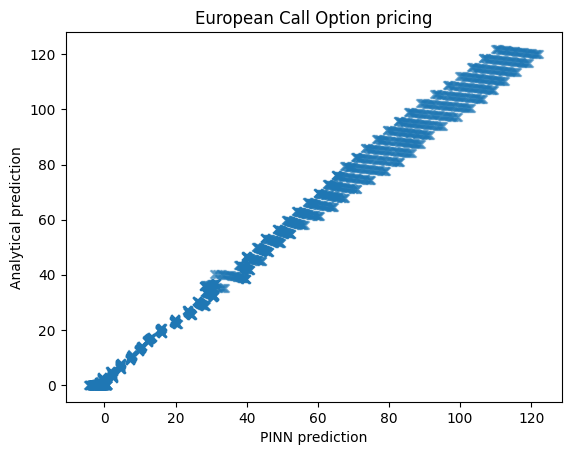

In [ ]:
plt.scatter(x= y_pinn_test.detach().numpy(), y = y_analytical_test.detach().numpy(), marker = "x", alpha = 0.5)
plt.xlabel("PINN prediction")
plt.ylabel("Analytical prediction")
plt.title("European Call Option pricing")

In [ ]:
y_pinn_test.detach().numpy().shape

(2500, 1)

In [ ]:
np.corrcoef(y_pinn_test.detach().numpy().reshape(y_pinn_test.shape[0],),y_analytical_test.detach().numpy())

array([[1.        , 0.99725639],
       [0.99725639, 1.        ]])

In [ ]:
%matplotlib inline

In [ ]:
# y_analytical_test.detach().numpy().shape

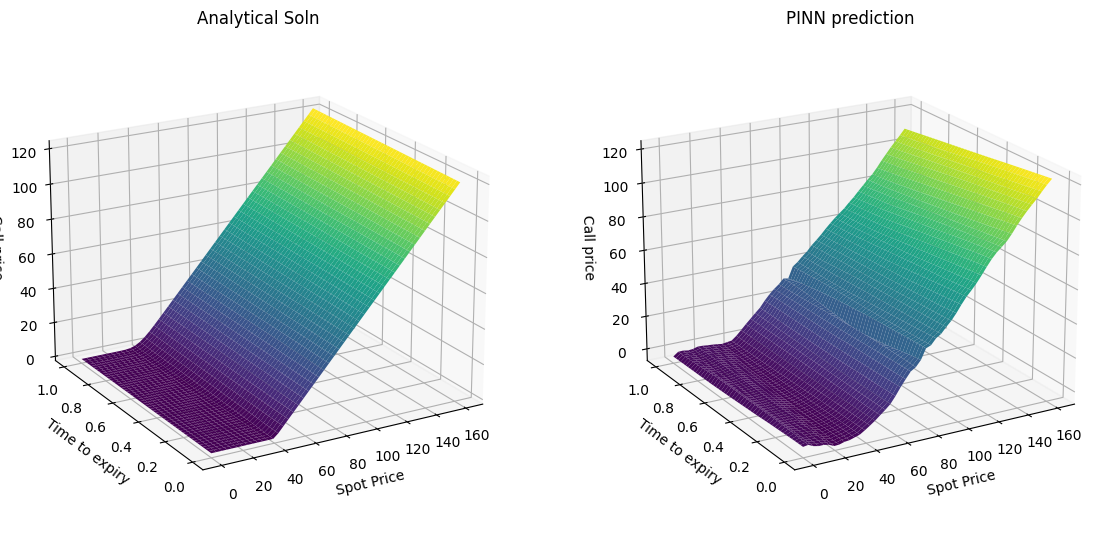

In [ ]:
# Create the 3D plot
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(s_grid, t_grid, y_analytical_test.detach().numpy().reshape(s_grid.shape), cmap = "viridis")
ax.set_title("Analytical Soln")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=20, azim=-120)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(s_grid, t_grid, y_pinn_test.detach().numpy().reshape(s_grid.shape), cmap = "viridis")
ax.set_title("PINN prediction")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=20, azim=-120)


torch.Size([50, 2]) torch.Size([50])


Text(0.5, 1.0, 'Analytical vs PINN price for t = 0.75')

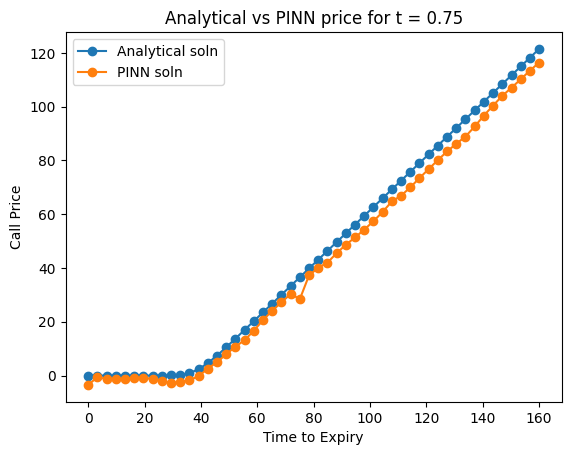

In [ ]:
s1 = np.linspace(S_range[0], S_range[1], 50)
t1 = np.array([0.75]*s1.shape[0])

# Create a 2D tensor from the flattened arrays
X_test1 = torch.tensor(np.column_stack((t1, s1)), dtype=torch.float)

y_analytical_test1 = eur_call_analytical_price(X_test1[:,1],X_test1[:,0],torch.tensor([K]), sigma = sigma)
print(X_test1.shape,y_analytical_test1.shape)

with torch.no_grad():
  y_pinn_test1a = model(X_test1)

plt.plot(s1, y_analytical_test1.detach().numpy(), marker='o', linestyle='-', label="Analytical soln")
plt.plot(s1, y_pinn_test1a.detach().numpy().reshape(s1.shape), marker='o', linestyle='-', label="PINN soln")
plt.xlabel('Time to Expiry')
plt.ylabel('Call Price')
plt.legend()
plt.title("Analytical vs PINN price for t = 0.75")

torch.Size([50, 2]) torch.Size([50])


Text(0.5, 1.0, 'Analytical vs PINN price for t = 0.25')

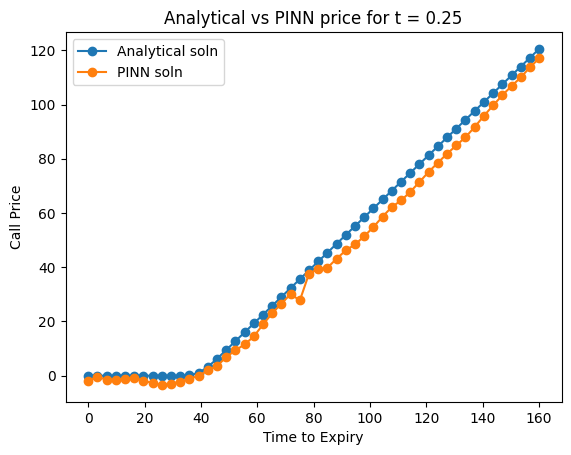

In [ ]:
s1 = np.linspace(S_range[0], S_range[1], 50)
t1 = np.array([0.25]*s1.shape[0])

# Create a 2D tensor from the flattened arrays
X_test1 = torch.tensor(np.column_stack((t1, s1)), dtype=torch.float)

y_analytical_test1 = eur_call_analytical_price(X_test1[:,1],X_test1[:,0],torch.tensor([K]), sigma = sigma)
print(X_test1.shape,y_analytical_test1.shape)

with torch.no_grad():
  y_pinn_test1a = model(X_test1)

plt.plot(s1, y_analytical_test1.detach().numpy(), marker='o', linestyle='-', label="Analytical soln")
plt.plot(s1, y_pinn_test1a.detach().numpy().reshape(s1.shape), marker='o', linestyle='-', label="PINN soln")
plt.xlabel('Time to Expiry')
plt.ylabel('Call Price')
plt.legend()
plt.title("Analytical vs PINN price for t = 0.25")